# Lab 3: Relational Data and Split-Apply-Combine

## Learning goals

- Learn how to group data and make summary statistics and group-wise transformations
- Learn how to combine data sets by concatanation
- Using pivot tables
- Visualise data using a grouped structure

## Literature

PDS Ch3: [Aggregation and Grouping](https://jakevdp.github.io/PythonDataScienceHandbook/03.08-aggregation-and-grouping.html), [Pivot Tables](https://jakevdp.github.io/PythonDataScienceHandbook/03.09-pivot-tables.html), [Concat and append](https://jakevdp.github.io/PythonDataScienceHandbook/03.06-concat-and-append.html) 
[Merge and join](https://jakevdp.github.io/PythonDataScienceHandbook/03.07-merge-and-join.html)


# Big-ish Data and Split-Apply-Combine

<iframe src="https://ntnu.cloud.panopto.eu/Panopto/Pages/Embed.aspx?id=e970028f-c92b-4fea-86bc-aee500be6948&autoplay=false&offerviewer=true&showtitle=true&showbrand=true&captions=false&interactivity=all" height="405" width="720" style="border: 1px solid #464646;" allowfullscreen allow="autoplay"></iframe>

When we are using big data sets it is often that our data is organised by group. For example, we might have observations of students within a school, days in a year, counties in a country, etc. 

Often we wish to create both numerical and graphical summaries over these groups. We may also wish to create new variables that are transformed by group: difference from a group mean for example.

Often we also wish to visualise data by groups - the number of Covid19 cases per country, for example. 

We do all these things with a unified frameworks called Split-Apply-Combine, which Pandas provides built-in functionality for. 

As usual we start by loading in the packages we need:


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('max_columns', None) # to show all columns of a pandas Data Frame

I also want to set some plot settings to make them prettier

In [2]:
from cycler import cycler

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["axes.labelsize"]= 12
plt.rcParams["figure.facecolor"] = "#f2f2f2"
#plt.rcParams['figure.savefig.dpi'] = 100
plt.rcParams['savefig.edgecolor'] = "#f2f2f2"
plt.rcParams['savefig.facecolor'] ="#f2f2f2"
plt.rcParams["figure.figsize"] = [16,10]
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 14
greens = ['#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
multi =['#66c2a4','#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
plt.rcParams["axes.prop_cycle"] = cycler(color=multi)



To demonstrate some of these techniques we will make use of a data set of Covid19 infections by country. 

This data set is from the R [*coronavirus* package](https://cran.r-project.org/web/packages/coronavirus/coronavirus.pdf) that collects data from the [Johns Hopkins University Center for Systems Science](https://systems.jhu.edu/research/public-health/ncov/). For convenience, we will load in the dataset directly from my website:

In [3]:
corona = pd.read_csv("https://jmaurit.github.io/anv_statistikk/data/coronavirus.csv")

/Users/johannesmauritzen/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


We can view our data:

In [4]:
corona

,date,province,country,lat,long,type,cases,uid,iso2,iso3,code3,combined_key,population,continent_name,continent_code
0,2020-01-22,Alberta,Canada,53.933300,-116.576500,confirmed,0,12401.0,CA,CAN,124.0,"Alberta, Canada",4413146.0,North America,NaN
1,2020-01-23,Alberta,Canada,53.933300,-116.576500,confirmed,0,12401.0,CA,CAN,124.0,"Alberta, Canada",4413146.0,North America,NaN
2,2020-01-24,Alberta,Canada,53.933300,-116.576500,confirmed,0,12401.0,CA,CAN,124.0,"Alberta, Canada",4413146.0,North America,NaN
3,2020-01-25,Alberta,Canada,53.933300,-116.576500,confirmed,0,12401.0,CA,CAN,124.0,"Alberta, Canada",4413146.0,North America,NaN
4,2020-01-26,Alberta,Canada,53.933300,-116.576500,confirmed,0,12401.0,CA,CAN,124.0,"Alberta, Canada",4413146.0,North America,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605545,2022-01-20,NaN,Zimbabwe,-19.015438,29.154857,recovery,0,716.0,ZW,ZWE,716.0,Zimbabwe,14862927.0,Africa,AF
605546,2022-01-21,NaN,Zimbabwe,-19.015438,29.154857,recovery,0,716.0,ZW,ZWE,716.0,Zimbabwe,14862927.0,Africa,AF
605547,2022-01-22,NaN,Zimbabwe,-19.015438,29.154857,recovery,0,716.0,ZW,ZWE,716.0,Zimbabwe,14862927.0,Africa,AF
605548,2022-01-23,NaN,Zimbabwe,-19.015438,29.154857,recovery,0,716.0,ZW,ZWE,716.0,Zimbabwe,14862927.0,Africa,AF


We see that we have data by country, and sometimes by province. 

By using the function unique(), we can see that the variable *type* has three values

In [5]:
corona.type.unique()

array(['confirmed', 'death', 'recovery'], dtype=object)

Let's say that we wish to see the total number of cases for each country and for each day. What we need to do is to sum up all the values for each type (confirmed, death, recovery) and each day.

To start with a simpler problem, lets say I just want to sum up for one country the total number of confirmed cases. Then I could do:

In [6]:
corona.loc[(corona.country=="Norway") & (corona.type=="confirmed"),"cases"].sum()

641138

Let's walk through what we have done:

* we use the .loc attribute to select our desired data, 

* Remembering that the format is .loc[row, column], we specific that we want all rows that satisfy two criteria: That country is Norway (corona.country=="Norway") AND (we use & to signify AND) type is "confirmed" (corona.type=="confirmed"). 

* We then also specify that we want to look at the column called "cases". 

* Finally we want to sum up all the values in the column "cases" for the rows specified. 

But it would be time consuming to do this individually for each group. Luckily, we have a much faster way of doing it:


In [7]:
totals = corona.groupby(["country", "type"])["cases"].sum()
totals

country      type     
Afghanistan  confirmed    159896
             death          7393
             recovery          0
Albania      confirmed    248070
             death          3305
                           ...  
Zambia       death          3900
             recovery          0
Zimbabwe     confirmed    228541
             death          5305
             recovery          0
Name: cases, Length: 588, dtype: int64

Now we have a dataset consisting of the total number of cases for each country and for each type. This is an example of what is referred to as Split-Apply-Combine methodology which is a very powerful and general data analysis work-flow. 

Let's walk through it: 

* First we use the groupby() function. Here we specify that we want to use the list of variables ["country", "type"] to group the data set by. This is the **Split** part, as in we are splitting into groups.
* Then we specify which column we want to look at - in this case the number of cases ("cases")
* We specify the function we wish to apply to each group - in this case the built-in function sum(). This is the **Apply** part as we apply a function to each group. 
* Finally all the values are combined into a new data set with country and type used as row-indexes, this is the **Combine** part. 



The above summation actually has one major flaw. For some countries, data is reported for both the country as a whole as well as for each province in the country. When we sum over all data for each country we therefor will double count leading to a total that has twice as many confirmed cases as is actually the case. 

We can change our code slightly to fix this mistake

In [8]:
totals =  corona.loc[corona.province.isna(),:].groupby(["country", "type"])["cases"].sum()
totals

country      type     
Afghanistan  confirmed    159896
             death          7393
             recovery          0
Albania      confirmed    248070
             death          3305
                           ...  
Zambia       death          3900
             recovery          0
Zimbabwe     confirmed    228541
             death          5305
             recovery          0
Name: cases, Length: 580, dtype: int64

Above we simply added the .loc[] attribute and specified that we only wished to include the data where the province variable is equal to NA data (that is missing data): corona.province.isna()

This demonstrates the power of python/pandas in data analysis. We can string together several commands into one line. 

The output above is in the format of a series with two row-indexes: country and type. We can reset the index making country and type into normal columns. This is helpful for plotting:

In [9]:
totals = totals.reset_index()
totals

,country,type,cases
0,Afghanistan,confirmed,159896
1,Afghanistan,death,7393
2,Afghanistan,recovery,0
3,Albania,confirmed,248070
4,Albania,death,3305
...,...,...,...
575,Zambia,death,3900
576,Zambia,recovery,0
577,Zimbabwe,confirmed,228541
578,Zimbabwe,death,5305


<AxesSubplot:xlabel='country'>

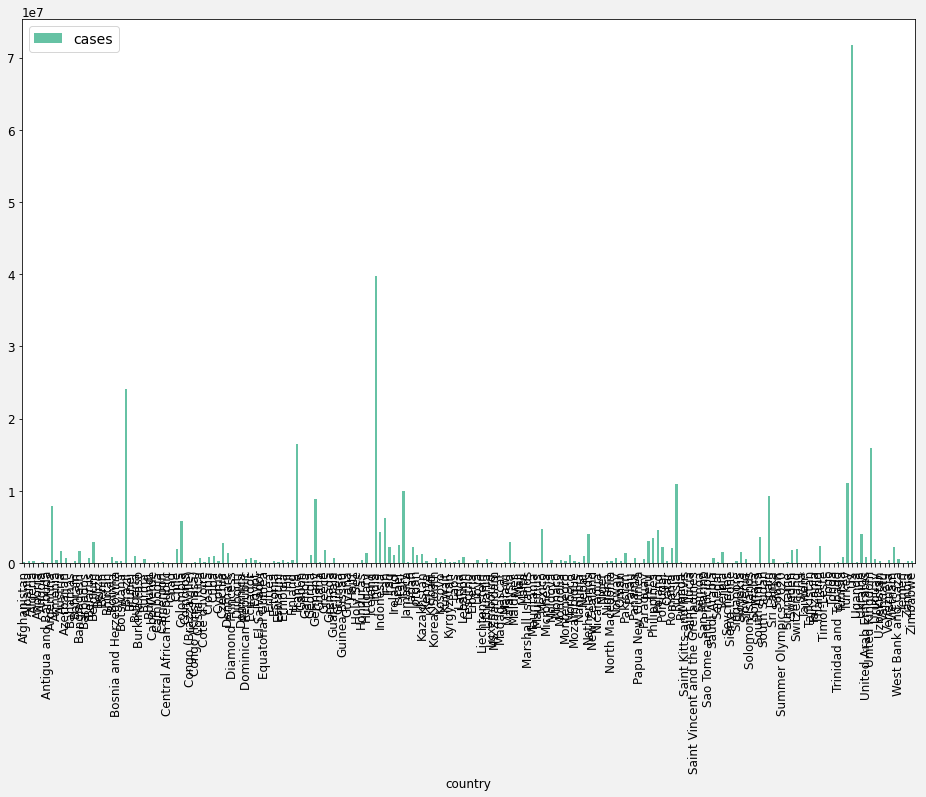

In [10]:
totals.loc[totals.type=="confirmed",:].plot(x="country", y="cases", kind="bar")

This figure clearly has some problems, but we will deal with such issues later. 

### Using group-by to plot mulitple lines

We can also use groupby to easily plot multiple series together. Let's say we want to compare the number of confirmed cases in the Nordic countries. We would do the following: 

In [11]:
nordics = ["Norway", "Sweden", "Denmark", "Finland"] #I know, I have left out tiny Iceland, sorry. 

nordicCorona = corona.loc[(corona.country.isin(nordics)) & (corona.province.isna()),:]
nordicCorona

,date,province,country,lat,long,type,cases,uid,iso2,iso3,code3,combined_key,population,continent_name,continent_code
96154,2020-01-22,NaN,Denmark,56.263900,9.501800,confirmed,0,208.0,DK,DNK,208.0,Denmark,5792203.0,Europe,EU
96155,2020-01-23,NaN,Denmark,56.263900,9.501800,confirmed,0,208.0,DK,DNK,208.0,Denmark,5792203.0,Europe,EU
96156,2020-01-24,NaN,Denmark,56.263900,9.501800,confirmed,0,208.0,DK,DNK,208.0,Denmark,5792203.0,Europe,EU
96157,2020-01-25,NaN,Denmark,56.263900,9.501800,confirmed,0,208.0,DK,DNK,208.0,Denmark,5792203.0,Europe,EU
96158,2020-01-26,NaN,Denmark,56.263900,9.501800,confirmed,0,208.0,DK,DNK,208.0,Denmark,5792203.0,Europe,EU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586461,2022-01-20,NaN,Sweden,60.128161,18.643501,recovery,0,752.0,SE,SWE,752.0,Sweden,10099270.0,Europe,EU
586462,2022-01-21,NaN,Sweden,60.128161,18.643501,recovery,0,752.0,SE,SWE,752.0,Sweden,10099270.0,Europe,EU
586463,2022-01-22,NaN,Sweden,60.128161,18.643501,recovery,0,752.0,SE,SWE,752.0,Sweden,10099270.0,Europe,EU
586464,2022-01-23,NaN,Sweden,60.128161,18.643501,recovery,0,752.0,SE,SWE,752.0,Sweden,10099270.0,Europe,EU


country
Denmark    AxesSubplot(0.125,0.125;0.775x0.755)
Finland    AxesSubplot(0.125,0.125;0.775x0.755)
Norway     AxesSubplot(0.125,0.125;0.775x0.755)
Sweden     AxesSubplot(0.125,0.125;0.775x0.755)
Name: cases, dtype: object

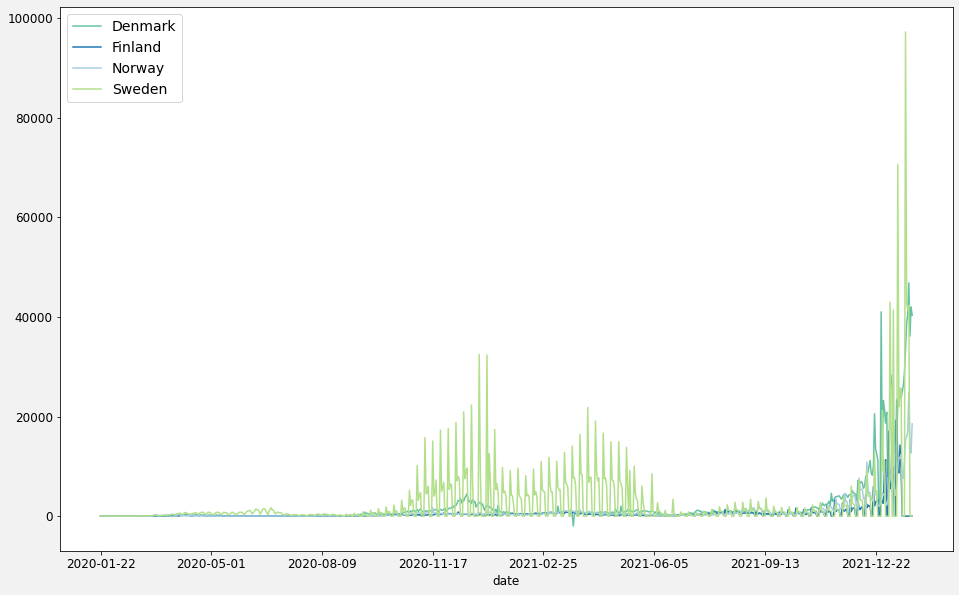

In [12]:

nordicCorona.loc[nordicCorona.type=="confirmed",:].set_index("date").groupby("country")["cases"].plot(legend=True)


Again, we do a lot on one line, but reading from left to right, we get a clear idea of the steps we are taking: 

1. Look only at confirmed cases (type=="confirmed")
2. Set the index to be equal to date (this way, the plotting software will know to use this as the x-axis
3. We group by country
4. Specify that we want to look at the variable/column cases ["cases"]
5. Then tell Pandas to plot the grouped series, while including a legend

## Aggregate and Transform

<iframe src="https://ntnu.cloud.panopto.eu/Panopto/Pages/Embed.aspx?id=c13d74c7-9eaf-426c-9217-aee500be6945&autoplay=false&offerviewer=true&showtitle=true&showbrand=true&captions=false&interactivity=all" height="405" width="720" style="border: 1px solid #464646;" allowfullscreen allow="autoplay"></iframe>

We are not limited to the built-in functions to apply to our grouped data. We can apply essentially any function (that takes an array as an input) by using the **aggregate** function.

Let's take the min, max and median of the number of confirmed cases for each country, as calculated by the associated numpy functions:

In [13]:
#Let me just limit my dataset to confirmed cases and excluding provinces first
coronaSimp = corona.loc[(corona.type=="confirmed") & (corona.province.isna()),:].copy()
#the .copy() function is a bit of a technicality.
#If we exclude this, then behind the scene coronaSimp would simply be pointing to a
#"slice" of corona - a way of saving on memory. But this can also lead to problems


summaryStats =  coronaSimp.groupby(["country"])["cases"].aggregate([np.min, np.median,np.max])
summaryStats

,amin,median,amax
country,,,
Afghanistan,-6,67.5,3243
Albania,0,152.5,4789
Algeria,0,217.5,2215
Andorra,0,8.0,2313
Angola,0,66.5,5035
...,...,...,...
Vietnam,0,9.0,39132
West Bank and Gaza,0,366.0,30356
Yemen,-1,5.0,174


Sometimes we don't want a summary of a group, but rather do a group-wise transformation where we are adding a new variable to an existing dataset. Here, we use **transform**. For example, let's say we want to transform the number of confirmed cases to be displayed as the difference from the mean number of cases. 

There are two equivalent ways of doing this - basically just two ways of writing a function. 

First, defining a function in the traditional way:

In [14]:
def diffMean(x):
    return(x-x.mean())


coronaSimp["diffMeanCases"] = coronaSimp.groupby(["country"])["cases"].transform(diffMean)


In [15]:
coronaSimp

,date,province,country,lat,long,type,cases,uid,iso2,iso3,code3,combined_key,population,continent_name,continent_code,diffMeanCases
63858,2020-01-22,NaN,Afghanistan,33.939110,67.709953,confirmed,0,4.0,AF,AFG,4.0,Afghanistan,38928341.0,Asia,AS,-217.841962
63859,2020-01-23,NaN,Afghanistan,33.939110,67.709953,confirmed,0,4.0,AF,AFG,4.0,Afghanistan,38928341.0,Asia,AS,-217.841962
63860,2020-01-24,NaN,Afghanistan,33.939110,67.709953,confirmed,0,4.0,AF,AFG,4.0,Afghanistan,38928341.0,Asia,AS,-217.841962
63861,2020-01-25,NaN,Afghanistan,33.939110,67.709953,confirmed,0,4.0,AF,AFG,4.0,Afghanistan,38928341.0,Asia,AS,-217.841962
63862,2020-01-26,NaN,Afghanistan,33.939110,67.709953,confirmed,0,4.0,AF,AFG,4.0,Afghanistan,38928341.0,Asia,AS,-217.841962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205515,2022-01-20,NaN,Zimbabwe,-19.015438,29.154857,confirmed,665,716.0,ZW,ZWE,716.0,Zimbabwe,14862927.0,Africa,AF,353.636240
205516,2022-01-21,NaN,Zimbabwe,-19.015438,29.154857,confirmed,409,716.0,ZW,ZWE,716.0,Zimbabwe,14862927.0,Africa,AF,97.636240
205517,2022-01-22,NaN,Zimbabwe,-19.015438,29.154857,confirmed,218,716.0,ZW,ZWE,716.0,Zimbabwe,14862927.0,Africa,AF,-93.363760
205518,2022-01-23,NaN,Zimbabwe,-19.015438,29.154857,confirmed,75,716.0,ZW,ZWE,716.0,Zimbabwe,14862927.0,Africa,AF,-236.363760


When we have very simple functions like the one above, we can also make use of short-hand "lambda" functions:

In [16]:
coronaSimp["diffMeanCases"] = coronaSimp.groupby(["country"])["cases"].transform(lambda x: x - x.mean())

# Combining data sets: Concatenating and merging

<iframe src="https://ntnu.cloud.panopto.eu/Panopto/Pages/Embed.aspx?id=31e6454e-8cf0-419d-b433-aee500be6954&autoplay=false&offerviewer=true&showtitle=true&showbrand=true&captions=false&interactivity=all" height="405" width="720" style="border: 1px solid #464646;" allowfullscreen allow="autoplay"></iframe>

### Concatenating

It is rare that you can simply load in the entire data set you are interested in. Often you have to construct a data set from several sources. In this section we will look at two methods for combining data set. 

First, we will look at the case where you have similar data sets along a certain axis which you wish to combine in a certain way. 

A common situation, for example, is to have time series data that is available in yearly (or other frequency) files, which you wish to combine into a larger data set. Below we import two yearly data files of wholesale electricity prices traded on the Nord Pool market. 

In [17]:
prices2019 = pd.read_csv("https://jmaurit.github.io/anv_statistikk/data/prices2019.csv", sep=";", decimal=",")
prices2020 = pd.read_csv("https://jmaurit.github.io/anv_statistikk/data/prices2020.csv", sep=";", decimal=",")

In [18]:
prices2020

,date,Hours,SYS,SE1,SE2,SE3,SE4,FI,DK1,DK2,Oslo,Kr.sand,Bergen,Molde,Tr.heim,Tromsø,EE,LV,LT,AT,BE,DE-LU,FR,NL
0,01/01/2020,00 - 01,30.84,28.78,28.78,28.78,28.78,28.78,33.42,33.42,31.82,31.82,31.82,28.78,28.78,28.78,28.78,28.78,28.78,41.88,41.88,41.88,41.88,41.88
1,01/01/2020,01 - 02,30.63,28.45,28.45,28.45,28.45,28.45,31.77,31.77,31.77,31.77,31.77,28.45,28.45,28.45,28.45,28.45,28.45,38.60,38.60,38.60,38.60,38.60
2,01/01/2020,02 - 03,30.38,27.90,27.90,27.90,27.90,27.90,31.57,31.57,31.57,31.57,31.57,27.90,27.90,27.90,27.90,27.90,27.90,36.55,36.55,36.55,36.55,36.55
3,01/01/2020,03 - 04,30.04,27.52,27.52,27.52,27.52,27.52,31.28,31.28,31.28,31.28,31.28,27.52,27.52,27.52,27.52,27.52,27.52,32.32,32.32,32.32,32.32,32.32
4,01/01/2020,04 - 05,29.56,27.54,27.54,27.54,27.54,27.54,30.85,30.85,30.72,30.72,30.72,27.54,27.54,27.54,27.54,27.54,27.54,30.85,30.85,30.85,30.85,30.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7051,20/10/2020,19 - 20,21.74,28.81,28.81,34.92,43.47,64.01,37.05,43.47,19.30,19.30,19.30,17.38,17.38,12.85,64.01,64.01,64.01,49.02,49.02,49.02,49.02,49.02
7052,20/10/2020,20 - 21,20.42,25.95,25.95,25.95,25.95,29.06,25.95,25.95,19.48,19.48,19.48,17.32,17.32,12.66,29.06,29.06,29.06,42.25,45.05,38.06,44.83,40.93
7053,20/10/2020,21 - 22,19.57,20.11,20.11,20.11,20.11,23.44,20.11,20.11,19.86,19.86,19.86,17.26,17.26,12.49,23.44,23.44,23.44,37.40,41.00,33.09,40.51,37.40
7054,20/10/2020,22 - 23,19.23,19.44,19.44,19.44,19.44,23.54,19.44,19.44,19.44,19.44,19.44,17.18,17.18,12.41,23.54,23.54,23.54,32.52,44.63,29.66,38.04,44.63


Before combining, what is important is that they have the same number of columns - in this case 24 (we use the attribute *shape* to check this. 

In [19]:
prices2020.shape

(7056, 24)

In [20]:
prices2019.shape

(8761, 24)

But the column names should also be the same, and if we look at the prices2019 dataframe, we see that the date variable is called *time* instead of *date* as in prices2020. This we can change by using the pd.rename() function:

In [21]:
prices2019 = prices2019.rename(columns={"Time": "date"})

Now we can combine these by using pd.concat() function, specifying that we wish to join them by the columns (axis=0)

In [22]:
prices = pd.concat([prices2019,prices2020], axis=0)

In [23]:
prices

,date,Hours,SYS,SE1,SE2,SE3,SE4,FI,DK1,DK2,Oslo,Kr.sand,Bergen,Molde,Tr.heim,Tromsø,EE,LV,LT,AT,BE,DE-LU,FR,NL
0,01/01/2019,00 - 01,44.55,28.32,28.32,28.32,28.32,28.32,28.32,28.32,48.77,48.77,48.77,45.36,45.36,45.36,28.32,28.32,28.32,NaN,NaN,NaN,NaN,NaN
1,01/01/2019,01 - 02,44.07,10.07,10.07,10.07,10.07,10.07,10.07,10.07,49.25,49.25,49.25,45.31,45.31,45.31,10.07,10.07,10.07,NaN,NaN,NaN,NaN,NaN
2,01/01/2019,02 - 03,41.12,10.03,10.03,10.03,10.03,10.03,-4.08,-4.08,49.17,49.17,49.17,45.37,45.37,45.37,10.03,10.03,10.03,NaN,NaN,NaN,NaN,NaN
3,01/01/2019,03 - 04,38.88,4.56,4.56,4.56,4.56,4.56,-9.91,-9.91,48.37,48.37,48.37,45.21,45.21,45.21,4.56,4.56,4.56,NaN,NaN,NaN,NaN,NaN
4,01/01/2019,04 - 05,35.70,4.83,4.83,4.83,4.83,4.83,-7.41,-7.41,47.19,47.19,47.19,44.90,44.90,44.90,4.83,4.83,4.83,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7051,20/10/2020,19 - 20,21.74,28.81,28.81,34.92,43.47,64.01,37.05,43.47,19.30,19.30,19.30,17.38,17.38,12.85,64.01,64.01,64.01,49.02,49.02,49.02,49.02,49.02
7052,20/10/2020,20 - 21,20.42,25.95,25.95,25.95,25.95,29.06,25.95,25.95,19.48,19.48,19.48,17.32,17.32,12.66,29.06,29.06,29.06,42.25,45.05,38.06,44.83,40.93
7053,20/10/2020,21 - 22,19.57,20.11,20.11,20.11,20.11,23.44,20.11,20.11,19.86,19.86,19.86,17.26,17.26,12.49,23.44,23.44,23.44,37.40,41.00,33.09,40.51,37.40
7054,20/10/2020,22 - 23,19.23,19.44,19.44,19.44,19.44,23.54,19.44,19.44,19.44,19.44,19.44,17.18,17.18,12.41,23.54,23.54,23.54,32.52,44.63,29.66,38.04,44.63


Just for fun, let's plot the series for Trondheim compared to Oslo in this period

<AxesSubplot:xlabel='date'>

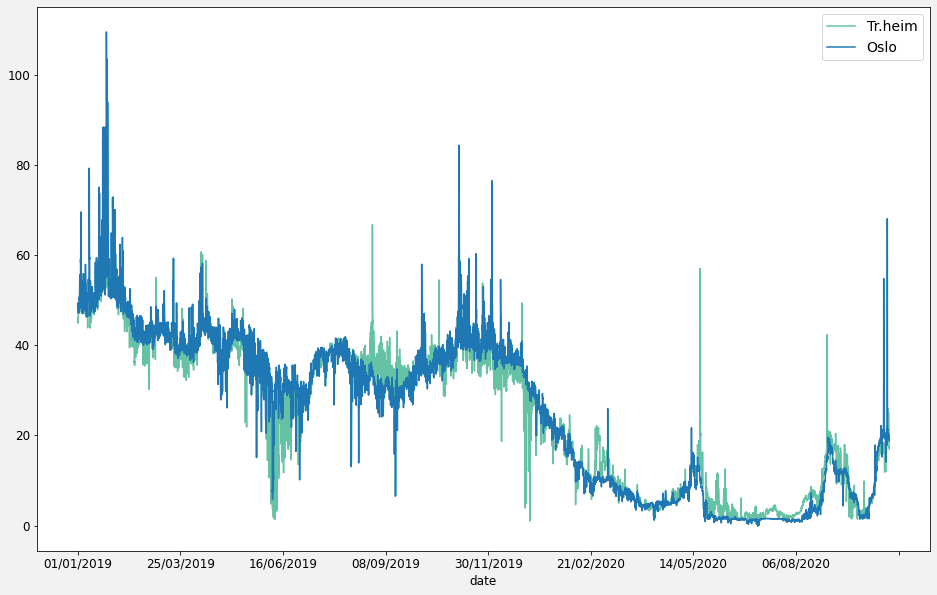

In [24]:
prices.loc[:, ["date", "Tr.heim", "Oslo"]].set_index("date").plot()

For more on simple concatanation, joining and appending see [PDS](https://jakevdp.github.io/PythonDataScienceHandbook/03.06-concat-and-append.html)

## Merging

For combining two or more similarily formed data sets, concatenating works well. But often we want to join messier data sets. We might, for example, wish to combine data on oil prices that is available at a daily frequency with electricity prices that are at a hourly frequency. We then have to use the **merge** functionality in Pandas. 

A little warning: Merging data sets is a fine art and many things can and do go wrong. Always check your data after doing a merge, especially for complicated data sets.

We will demonstrate merging by combining the total confirmed infections data we created earlier in this lab with the data available from the Penn world tables. We will then see if we can see any relationships between confirmed infections and the economic data in the Penn World Tables. 

<iframe src="https://ntnu.cloud.panopto.eu/Panopto/Pages/Embed.aspx?id=d0311199-efd4-438f-af13-aee500be6949&autoplay=false&offerviewer=true&showtitle=true&showbrand=true&captions=false&interactivity=all" height="405" width="720" style="border: 1px solid #464646;" allowfullscreen allow="autoplay"></iframe>

In [25]:
pwt = pd.read_csv("https://jmaurit.github.io/anv_statistikk/data/pwt100.csv", sep=";", decimal=",")


In [26]:
pwt2019 = pwt.loc[(pwt.year==2019)].copy()


In [27]:
totals

,country,type,cases
0,Afghanistan,confirmed,159896
1,Afghanistan,death,7393
2,Afghanistan,recovery,0
3,Albania,confirmed,248070
4,Albania,death,3305
...,...,...,...
575,Zambia,death,3900
576,Zambia,recovery,0
577,Zimbabwe,confirmed,228541
578,Zimbabwe,death,5305


In [28]:
pwt2019Plus = pd.merge(pwt2019, totals.loc[totals.type=="confirmed"] , on="country", how="left")

Just to check, we can look at the row for Norway

In [29]:
pwt2019Plus.loc[pwt2019Plus.country=="Norway"]

,countrycode,country,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,ccon,cda,cgdpe,cgdpo,cn,ck,ctfp,cwtfp,rgdpna,rconna,rdana,rnna,rkna,rtfpna,rwtfpna,labsh,irr,delta,xr,pl_con,pl_da,pl_gdpo,i_cig,i_xm,i_xr,i_outlier,i_irr,cor_exp,statcap,csh_c,csh_i,csh_g,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k,type,cases
127,NOR,Norway,Norwegian Krone,2019,336415.4063,396253.875,5.378857,2.853662,1384.073291,3.662843,216700.5156,329255.875,335132.25,388492.4688,1723067.25,0.023208,1.03004,0.839606,377715.3438,215975.7969,329937.8125,1723175.125,1.054514,0.977179,0.996919,0.528504,0.061986,0.038229,8.8,1.288979,1.203514,1.038209,Extrapolated,Extrapolated,Market-based,Regular,Regular,NaN,NaN,0.37418,0.289723,0.183618,0.513056,-0.33377,-0.026808,1.243976,1.038969,1.380687,0.521929,0.664356,0.97813,0.948889,confirmed,641138.0


Let us walk through the merge code. 

- Within the pd.merge() function we first have a left data frame (pwt2019) and right data frame (totals - limited to confirmed cases). 

- We then specify on which column we wish to match the data frame. In this case we want to match country-to-country, and so we specify the country column. Luckily for us, both the column name is the same in both data frames, and the format of the countries are the same.

- Finally we then specify a **how** parameter - here "left". What this means is that based on all the rows of the left data frame we want to try to find a corresponding row in the right data frame. If no corresponding value can be found, then a NaN will be set instead. For example, there is no infection data from Aruba, so a NaN value is put in the column *cases* for that row. Other options are "inner", where only rows where the country can be found in both data frame and "outer" where we include rows for each country if it exists in any of the two data frames.



In [30]:
pwt2019Plus

,countrycode,country,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,ccon,cda,cgdpe,cgdpo,cn,ck,ctfp,cwtfp,rgdpna,rconna,rdana,rnna,rkna,rtfpna,rwtfpna,labsh,irr,delta,xr,pl_con,pl_da,pl_gdpo,i_cig,i_xm,i_xr,i_outlier,i_irr,cor_exp,statcap,csh_c,csh_i,csh_g,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k,type,cases
0,ABW,Aruba,Aruban Guilder,2019,3921.261230,3467.299561,0.106314,0.047601,NaN,NaN,3023.694824,3877.659668,3912.334717,3466.241943,1.845813e+04,0.000220,NaN,NaN,3068.758301,3018.355957,3887.623779,1.842750e+04,1.026229,NaN,NaN,0.645106,0.043163,0.035241,1.790000,0.849037,0.841709,0.950033,Extrapolated,Extrapolated,Market-based,Regular,Regular,NaN,NaN,0.658242,0.246366,0.214084,0.973115,-1.091808,2.125690e-07,0.883092,0.815759,0.744329,0.707260,0.622660,0.813961,0.616383,NaN,NaN
1,AGO,Angola,Kwanza,2019,228151.015600,227855.718800,31.825295,16.644962,NaN,1.481984,155943.718800,198750.421900,227771.609400,223289.312500,1.371321e+06,0.017415,0.380317,0.325579,222151.062500,155270.703100,198864.734400,1.367458e+06,1.003396,0.937804,0.917951,0.331142,0.109524,0.043388,364.825805,0.381504,0.373184,0.380675,Extrapolated,Extrapolated,Market-based,Regular,Regular,NaN,48.888900,0.498670,0.191710,0.199723,0.344351,-0.113983,-1.204703e-01,0.438169,0.342872,0.240024,0.476486,0.611627,0.209101,0.378033,confirmed,97263.0
2,AIA,Anguilla,East Caribbean Dollar,2019,376.634979,225.680527,0.014869,NaN,NaN,NaN,438.470032,509.044983,375.136444,241.384537,2.385742e+03,NaN,NaN,NaN,223.456711,457.463562,527.833801,2.379582e+03,NaN,NaN,NaN,NaN,NaN,0.026001,2.700000,1.009066,1.011857,1.572530,Extrapolated,Extrapolated,Market-based,Regular,NaN,NaN,NaN,1.513381,0.292376,0.303098,1.480300,-2.445801,-1.433542e-01,1.064513,1.029199,0.732212,0.768944,0.602734,0.902942,NaN,NaN,NaN
3,ALB,Albania,Lek,2019,35890.019530,36103.042970,2.880917,1.075898,NaN,2.964992,33399.167970,40868.316410,35808.343750,36288.328130,2.298183e+05,NaN,NaN,NaN,37204.773440,33426.441410,40984.562500,2.278046e+05,NaN,NaN,NaN,NaN,NaN,0.027732,109.850833,0.419904,0.426662,0.421019,Extrapolated,Extrapolated,Market-based,Regular,NaN,NaN,78.888900,0.714312,0.205828,0.206071,0.126594,-0.313949,6.114468e-02,0.473077,0.456882,0.235589,0.629832,0.525463,0.299344,NaN,confirmed,248070.0
4,ARE,United Arab Emirates,UAE Dirham,2019,681525.812500,645956.250000,9.770529,5.808834,NaN,2.746695,306771.156300,515623.312500,678241.187500,635332.812500,4.510360e+06,NaN,NaN,NaN,647986.250000,306717.031300,533594.312500,4.506529e+06,NaN,NaN,NaN,NaN,NaN,0.036909,3.672500,0.716486,0.620933,0.662869,Extrapolated,Extrapolated,Market-based,Regular,NaN,NaN,NaN,0.355746,0.328729,0.127105,0.889652,-0.701231,-4.849210e-07,0.725061,0.480580,0.692488,0.688882,0.647336,0.268754,NaN,confirmed,828328.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,VNM,Viet Nam,Dong,2019,750726.750000,724123.375000,96.462106,50.399563,2131.968232,2.869998,582677.062500,758821.937500,747853.750000,723142.687500,2.009263e+06,NaN,NaN,NaN,741653.562500,582796.000000,762540.875000,2.011976e+06,NaN,NaN,NaN,NaN,NaN,0.053946,23050.241670,0.335440,0.350231,0.362199,Extrapolated,Extrapolated,Market-based,Regular,NaN,NaN,78.888900,0.710267,0.243582,0.095490,0.526032,-0.518066,-5.730492e-02,0.347591,0.399158,0.245056,0.695617,0.676502,0.249071,NaN,NaN,NaN
179,YEM,Yemen,Yemeni Rial,2019,50052.933590,51828.058590,29.161922,5.531877,NaN,1.842989,49266.472660,67992.531250,49937.042970,51983.429690,5.485533e+05,NaN,NaN,NaN,40069.593750,49169.070310,64330.738280,5.502327e+05,NaN,NaN,NaN,NaN,NaN,0.029836,250.250000,0.598363,0.499337,0.479680,Extrapolated,Extrapolated,Market-based,Regular,NaN,NaN,38.888867,0.647500,0.360231,0.300234,0.000723,-0.135297,-1.733917e-01,0.777612,0.238807,0.211786,0.632594,0.670528,0.171695,NaN,confirmed,10585.0
180,ZAF,South Africa,Rand,2019,7489

Here I get rid of rows where there is a NaN value in the cases column, using the notna() function

In [31]:
pwt2019Plus = pwt2019Plus.loc[pwt2019Plus.cases.notna()].copy()

Now lets say we want to compare real gdp per capita with the number of infections per capita. First we need to create new per-capita variables.

In [32]:
pwt2019Plus["rgdpe_per_pers"] = pwt2019Plus.loc[:, "rgdpe"]/pwt2019Plus.loc[:, "pop"]

In [33]:
pwt2019Plus["cases_per_pers"] = pwt2019Plus.loc[:, "cases"]/pwt2019Plus.loc[:,"pop"]/1000000

We divide by 1 million above since the *pop* variable is in millions of people

In [34]:
pwt2019Plus.to_csv("data/pwt2019plus.csv", index=False) #index=False avoids saving the index to the csv file

We can start by looking at a histogram of cases per capital


<AxesSubplot:ylabel='Frequency'>

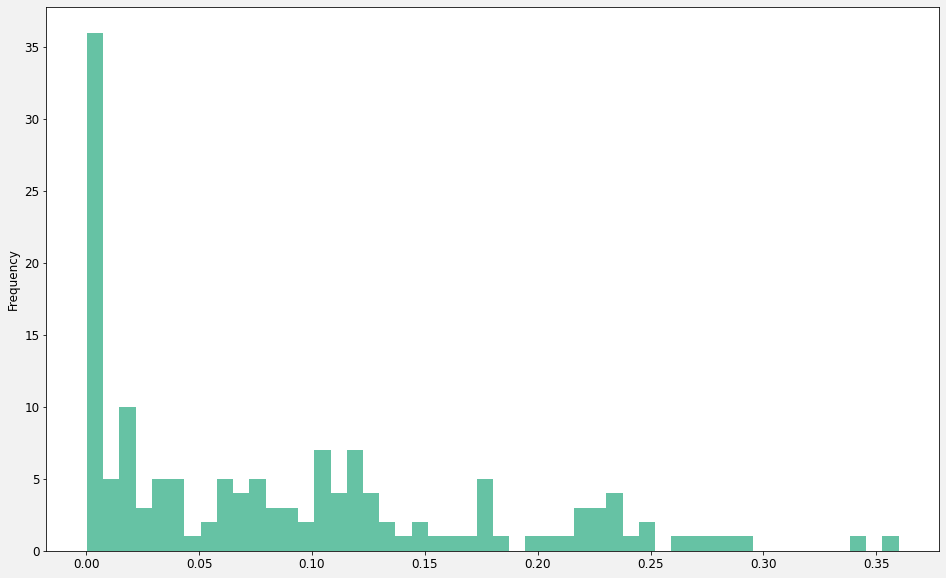

In [35]:

pwt2019Plus.cases_per_pers.plot.hist(bins=50)


Now let's create a scatter plot of per person gdp vs infections per pers

<AxesSubplot:xlabel='rgdpe_per_pers', ylabel='cases_per_pers'>

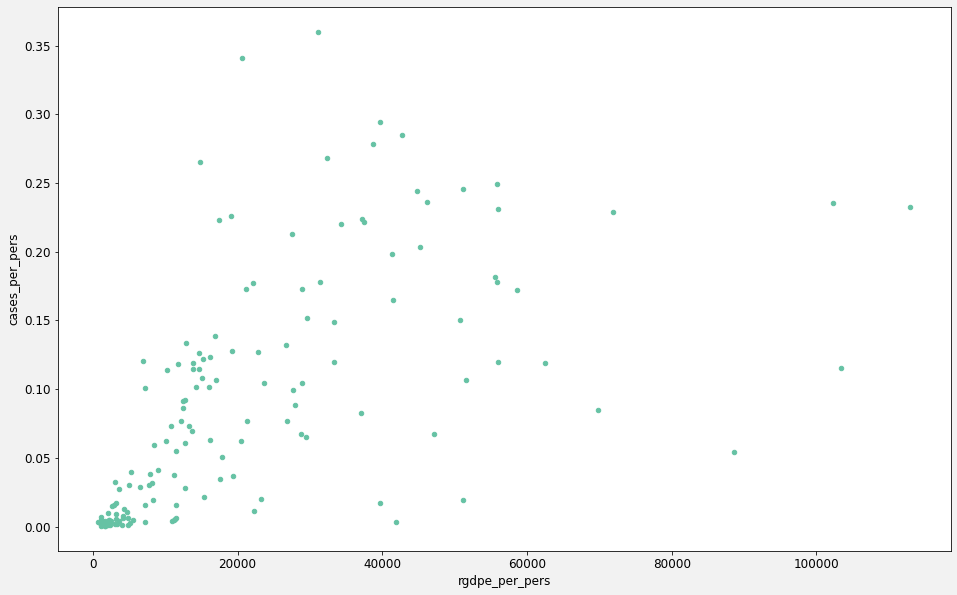

In [36]:
pwt2019Plus.plot.scatter(x="rgdpe_per_pers", y="cases_per_pers")

Do we see any pattern to this data? 

If we fit a regression line to this data what would it look like? 

Can you think of an explanation for the relationship?

# Assignments

### 1.  Split-apply combine of the corona dataset

a. Group the corona dataset by day and type and generate sums of cases for each day by type.

b. Plot lines for total number of global cases by type

c. Discuss how you might interpret this data and the potential problems with interpreting the data

### 2. Concatenating data sets

a. Download data for prices in the Nordic electricity market for 2018 - use this url: 

http://jmaurit.github.io/anv_statistikk/data/prices2018.csv

Combine this data with the 2019-2020 data we combined in the lab. Make sure to check that columns and column names combine. 

b. In a chart, compare price developments in the DK1 price area and the Oslo price area in this time frame.





### 3. Merging data sets

In this exercise we will combine parts of our electricity price data with data on wind power production in Denmark. 

a. Download and combine datasets for wind power in Denmark for 2018, 2019 and 2020. Use the following URLs:

http://jmaurit.github.io/anv_statistikk/data/dkwind2018.csv

http://jmaurit.github.io/anv_statistikk/data/dkwind2019.csv

http://jmaurit.github.io/anv_statistikk/data/dkwind2020.csv

Using concatanation, combine the three files into one data frame. 

b. Now extract from the electricity price series columns for date, hour, and prices for the two danish price areas (DK1 and DK2). Merge this data frame with the data on danish wind power in the two price areas. (For an extra challenge, you can try to create a new variable that consists of both date and hour elements: Pandas help pages on [working with strings](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html) and [datetime objects](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#converting-to-timestamps) will be helpful.)

c. Create a scatter plot of danish electricity prices and wind power. Can you see any correlation? What are the correlation coefficients between prices and wind power in the two areas.